In [72]:
# Dependencies
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
import calendar #necessary to convert a timestamp into a date
#from datetime import datetime
import time
import seaborn as sns
from __future__ import division

In [73]:
path_train = "/Users/louis/Documents/DataScience/animals_shelter/train.csv"
data = pd.read_csv(path_train)

In [74]:
%run '/Users/louis/Documents/DataScience/animals_shelter/processing_animals.py'

In [75]:
datap = process_data(data)

# Understanding the data

First exploration and quality check:
- all lines correspond to one animal, there are no duplicates
- the dataset goes from '2013-10-01 09:31:00'to '2016-02-21 19:17:00'
- There are 4 types of outcomes : Adoption, Transfer, Return_to_owner, Euthanasia, Death
- apprx half of the subtypeoutcomes are NaNs
- There are only cats and dogs
- there are neutered males, spayed females, spayed males, intact males, intacted females, and unknowns

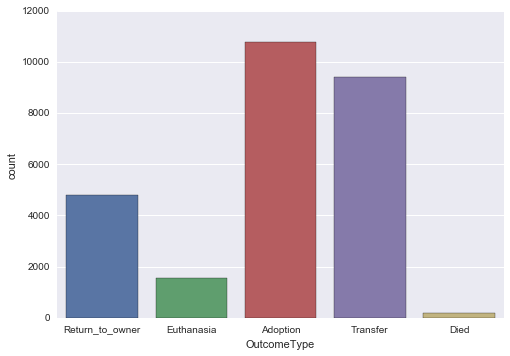

In [5]:
# Distribution of outcomes
sns.countplot(data = datap, x = 'OutcomeType')

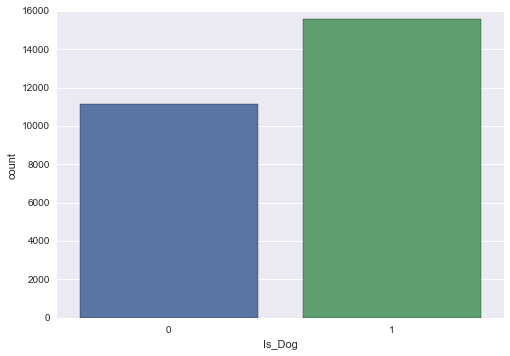

In [6]:
sns.countplot(data = datap, x = 'Is_Dog')

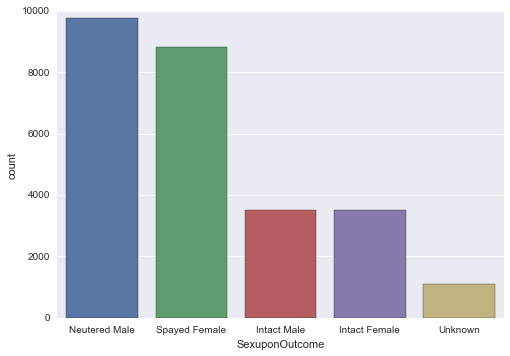

In [7]:
sns.countplot(data = datap, x = 'SexuponOutcome')

# Visually understanding the impact of parameters

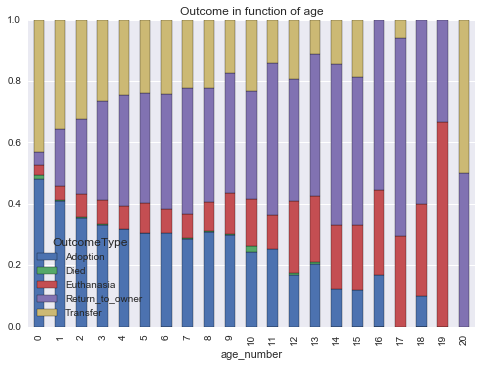

In [8]:
piv = pd.pivot_table(data, index = 'OutcomeType', columns = 'age_number', aggfunc = 'count')['SexuponOutcome']
piv_div = piv.sum(axis = 0)
piv_ratio = piv.apply(lambda row: row.div(piv_div), axis = 1)
piv_ratio.T.plot(kind = 'bar', stacked = True, title = 'Outcome in function of age')

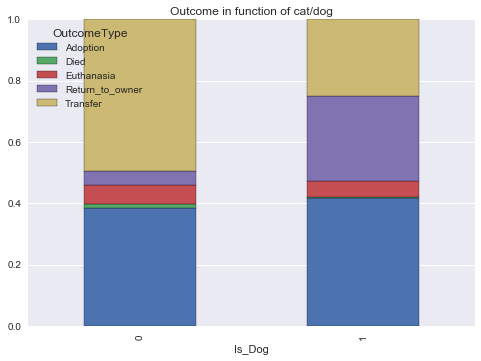

In [9]:
piv = pd.pivot_table(data, index= 'OutcomeType', columns = 'Is_Dog', aggfunc = 'count')['Month']
piv_sum = piv.sum(axis = 0)

piv_ratio = piv.apply(lambda row: row.div(piv_sum), axis = 1)
piv_ratio.T.plot(kind = 'bar', stacked = True, title = 'Outcome in function of cat/dog')

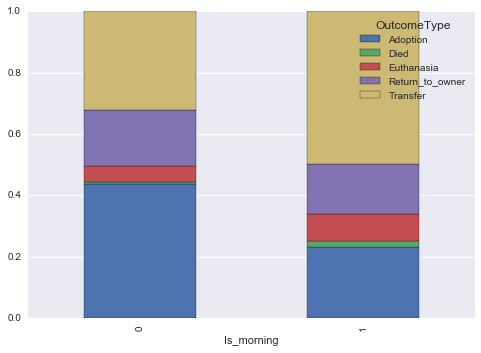

In [10]:
piv = pd.pivot_table(datap, index = 'Is_morning', columns = 'OutcomeType', aggfunc = 'count')['Month']
piv_sum = piv.sum(axis = 1)
piv_ratio = piv.apply(lambda column: column.div(piv_sum), axis = 0)
piv_ratio.plot(kind = 'bar', stacked = True)

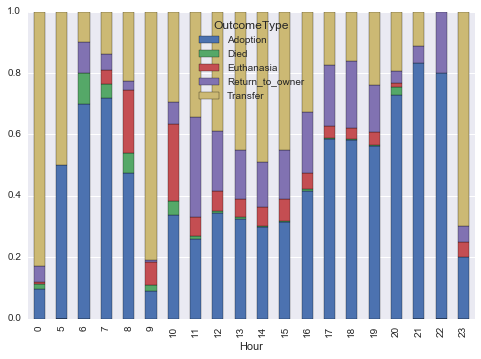

In [6]:
piv = pd.pivot_table(data, index = 'OutcomeType', columns = 'Hour', aggfunc = 'count')['Name_known']
piv_sum = piv.sum(axis = 0)
piv_ratio = piv.apply(lambda row: row.div(piv_sum), axis = 1)
piv_ratio.T.plot(kind = 'bar', stacked = True)

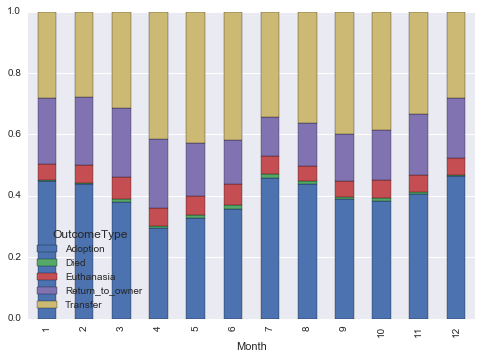

In [12]:
# Fate of animals in function of months
piv = pd.pivot_table(datap, index = 'OutcomeType', columns = 'Month', aggfunc = 'count')['SexuponOutcome']
piv_sum = piv.sum(axis = 0)
piv_div = piv.apply(lambda row: row.div(piv_sum), axis = 1)
piv_div.T.plot(kind = 'bar', stacked = True)

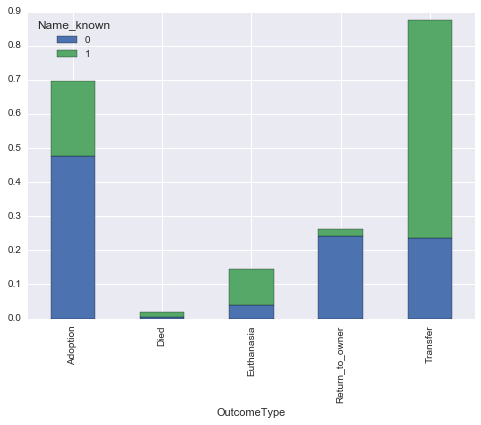

In [13]:
# Impact of name known vs unknown
piv = pd.pivot_table(datap, index = 'OutcomeType', columns = 'Name_known', aggfunc = 'count')['Is_morning']
piv_sum = piv.sum(axis = 0)
piv_ratio = piv.apply(lambda row: row.div(piv_sum), axis = 1)
piv_ratio.plot(kind = 'bar', stacked = True)

**Conclusion**: (i) Cats without name are rarely returned to owner (most likely because they do not have a owner) (ii) Cats whose name is known are more likely ti be transferred (iii) cats whose name is not known are more likely to be adopted

# Processing the data for modeling

In [1]:
# Dependencies
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
import calendar #necessary to convert a timestamp into a date
#from datetime import datetime
import time
import seaborn as sns
from __future__ import division

In [2]:
%run '/Users/louis/Documents/DataScience/animals_shelter/processing_animals.py'
path_train = "/Users/louis/Documents/DataScience/animals_shelter/train.csv"
data = pd.read_csv(path_train)
datap = process_data(data)

In [3]:
datap.head()

,OutcomeType,Name_known,Month,Hour,Is_morning,Is_Dog,Age_known,age_number,age_metric,Is_mix,Sex,State
0,Return_to_owner,0,2,18,0,1,1,1,years,1,Male,Neutered
1,Euthanasia,0,10,12,0,0,1,1,years,1,Female,Spayed
2,Adoption,0,1,12,0,1,1,2,years,1,Male,Neutered
3,Transfer,1,7,19,0,0,1,0,weeks,1,Male,Intact
4,Transfer,1,11,12,0,1,1,2,years,0,Male,Neutered


In [4]:
features_to_dummify = ['Sex', 'State', 'Month', 'Hour', 'age_metric']
data_model = dummify_data(datap, features_to_dummify )
data_model.head(2)

<string>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,OutcomeType,Name_known,Is_morning,Is_Dog,Age_known,age_number,Is_mix,Hour,Sex_Female,Sex_Male,...,Month_5,Month_6,Month_7,Month_8,Month_9,age_metric_Unknown,age_metric_days,age_metric_month,age_metric_weeks,age_metric_years
0,Return_to_owner,0,0,1,1,1,1,18,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Euthanasia,0,0,0,1,1,1,12,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Logistic regression

In [5]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics
%run '/Users/louis/Documents/DataScience/animals_shelter/post_analysis.py'

In [6]:
Y = data_model['OutcomeType']
del data_model['OutcomeType']

In [7]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_model, Y, test_size=0.2, random_state=0)

In [8]:
# Instantiate the logistic regression
log_reg = linear_model.LogisticRegression(fit_intercept = True, multi_class = 'ovr', C= 0.5, penalty = 'l1')

In [9]:
# train the model
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
# predict
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [11]:
# Compute metrics
# Test metrics
print '---------------Results on training-----------'
print 'Accuracy %s'%metrics.accuracy_score(y_train, y_train_pred)
#print 'F score %s' %metrics.f1_score(y_train, y_train_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_train_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_train_pred)

print '---------------Results on test-------------'
print 'Accuracy %s'%metrics.accuracy_score(y_test, y_test_pred)
#print 'F score %s' %metrics.f1_score(y_test, y_test_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_test_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_test_pred)

---------------Results on training-----------
Accuracy 0.648225225647
---------------Results on test-------------
Accuracy 0.650579872802


In [12]:
get_metrics(y_test, y_test_pred)

----------------Metrics of Adoption---------------
Precision :  0.878184344604
Recall :  0.640973630832
----------------Metrics of Transfer---------------
Precision :  0.658174097665
Recall :  0.736779560309
----------------Metrics of Return_to_owner---------------
Precision :  0.346315789474
Recall :  0.483113069016
----------------Metrics of Euthanasia---------------
Precision :  0.0403726708075
Recall :  0.541666666667
----------------Metrics of Died---------------
Precision :  0.0
Recall :  nan


In [13]:
get_metrics(y_train, y_train_pred)

----------------Metrics of Adoption---------------
Precision :  0.863414634146
Recall :  0.637783115992
----------------Metrics of Transfer---------------
Precision :  0.666887768639
Recall :  0.730350138021
----------------Metrics of Return_to_owner---------------
Precision :  0.351668404588
Recall :  0.487884267631
----------------Metrics of Euthanasia---------------
Precision :  0.0413625304136
Recall :  0.645569620253
----------------Metrics of Died---------------
Precision :  0.0
Recall :  nan


In [14]:
accuracy_scores = cross_validation.cross_val_score(log_reg, data_model, Y, cv=5, scoring='accuracy')
print accuracy_scores

[ 0.64771877  0.64522162  0.64677268  0.6424696   0.65288174]


In [29]:
# Grid search on the logistic regression
from sklearn import grid_search
log_reg_gridsearch = linear_model.LogisticRegression( multi_class = 'ovr', fit_intercept = True)
parameters = {'C': [ i*0.1 for i in range(1,10)], "penalty": ["l1", 'l2'] }
clf = grid_search.GridSearchCV(log_reg_gridsearch,parameters, cv = 4)
# train
clf.fit(data_model, Y)
# best params
clf.best_params_

{'C': 0.5, 'penalty': 'l1'}

In [39]:
# Analyze regression results
from sklearn import metrics
labels = ['Adoption', 'Transfer', 'Return_to_owner', 'Euthanasia', 'Died']
conf_mat = metrics.confusion_matrix(y_test, y_test_pred, labels = labels)
conf_mat

array([[1921,  103,  135,    0,    0],
       [ 555, 1221,  100,    8,    0],
       [ 547,  117,  285,    1,    0],
       [  64,  193,   56,    9,    0],
       [   2,   26,    2,    1,    0]])

**Conclusion** (i) we categorize a lot of transfers and return_to_owner into adoption (ii) we categorize return_to_owner into transfers (iii) we categorize euthanasia into transfers

We are particularly bad at discriminating death from transfers

In [41]:
data_model.columns.values

array(['Name_known', 'Is_morning', 'Is_Dog', 'Age_known', 'age_number',
       'Is_mix', 'Hour', 'Sex_Female', 'Sex_Male', 'Sex_Unknown',
       'State_Intact', 'State_Neutered', 'State_Spayed', 'State_Unknown',
       'Month_1', 'Month_10', 'Month_11', 'Month_12', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9'], dtype=object)

# Support vector classifier

In [ ]:
from sklearn import svm

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_model, Y, test_size=0.2, random_state=0)
sv = svm.LinearSVC()
sv.fit(X_train, y_train)

In [ ]:
# predict
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [ ]:
# Compute metrics
# Test metrics
print '---------------Results on training-----------'
print 'Accuracy %s'%metrics.accuracy_score(y_train, y_train_pred)
#print 'F score %s' %metrics.f1_score(y_train, y_train_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_train_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_train_pred)

print '---------------Results on test-------------'
print 'Accuracy %s'%metrics.accuracy_score(y_test, y_test_pred)
#print 'F score %s' %metrics.f1_score(y_test, y_test_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_test_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_test_pred)

In [ ]:
data['Is_mix'] = data['Breed'].map(lambda breed: 1 if 'Mix' in Breed else 0)

In [ ]:
data['Breed']

In [ ]:
# Next steps
1. Understand what we do not predict well
1 bis. Read what other on Kaggle did
3. adjust
4. Run Random Forest
4. Read on features engineering (try, for the exercice to multiply few variables)
5. Create a pipeline for the exercice

# Decision tree

In [2]:
# Dependencies
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
import calendar #necessary to convert a timestamp into a date
#from datetime import datetime
import time
import seaborn as sns
from __future__ import division
from sklearn import tree
from sklearn import cross_validation
from sklearn import metrics

In [3]:
path_train = "/Users/louis/Documents/DataScience/animals_shelter/train.csv"
data = pd.read_csv(path_train)

In [4]:
%run '/Users/louis/Documents/DataScience/animals_shelter/processing_animals.py'
%run '/Users/louis/Documents/DataScience/animals_shelter/dummify_data.py'
datap = process_data(data)
features_to_dummify = ['Sex', 'State', 'Month', 'Hour', 'age_metric', 'simpl_breed', 'simpl_color']
data_tree = dummify_data(datap, features_to_dummify)

<string>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# change all classes to int
#dict_age_metric = {'years':1, 'month': 2, 'weeks':3, 'days':4, 'Unknown':0}
#datap['age_metric'] = datap['age_metric'].map(dict_age_metric)
#dict_sex = {'Unknown': 0, 'Male': 1, 'Female': 2}
#datap['Sex'] = datap['Sex'].map(dict_sex)
#dict_state = {'Unknown': 0, 'Neutered': 1, 'Spayed': 1, 'Intact': 2}
#datap['State'] = datap['State'].map(dict_state)

In [6]:
Y = data_tree['OutcomeType']
del data_tree['OutcomeType']

data_tree.head()

,Name_known,Is_morning,Is_Dog,Age_known,age_number,Is_mix,Hour,Sex_Female,Sex_Male,Sex_Unknown,...,simpl_color_White/Brown,simpl_color_White/Chocolate,simpl_color_White/Cream,simpl_color_White/Flame,simpl_color_White/Gray,simpl_color_White/Lynx,simpl_color_White/Orange,simpl_color_White/Red,simpl_color_White/Yellow,simpl_color_Yellow
0,0,0,1,1,1,1,18,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,1,1,12,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1,1,2,1,12,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,1,0,1,19,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,1,1,2,0,12,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_tree, Y, test_size=0.2, random_state=0)

In [31]:
dt = tree.DecisionTreeClassifier(max_depth = 8)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [32]:
y_train_pred =dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [33]:
# Compute metrics
# Test metrics
print '---------------Results on training-----------'
print 'Accuracy %s'%metrics.accuracy_score(y_train, y_train_pred)
#print 'F score %s' %metrics.f1_score(y_train, y_train_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_train_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_train_pred)

print '---------------Results on test-------------'
print 'Accuracy %s'%metrics.accuracy_score(y_test, y_test_pred)
#print 'F score %s' %metrics.f1_score(y_test, y_test_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_test_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_test_pred)

---------------Results on training-----------
Accuracy 0.676752560445
---------------Results on test-------------
Accuracy 0.663112607557


In [37]:
features = pd.DataFrame(zip(data_tree.columns.values, dt.feature_importances_)).sort_values(1, ascending = False)

# Feature selection on decision tree

In [47]:
from sklearn import feature_selection

In [48]:
dt_select = feature_selection.RFE(dt, n_features_to_select = 50)

In [49]:
dt_select.fit(X_train, y_train)
y_train_pred =dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [50]:
# Compute metrics
# Test metrics
print '---------------Results on training-----------'
print 'Accuracy %s'%metrics.accuracy_score(y_train, y_train_pred)
#print 'F score %s' %metrics.f1_score(y_train, y_train_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_train_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_train_pred)

print '---------------Results on test-------------'
print 'Accuracy %s'%metrics.accuracy_score(y_test, y_test_pred)
#print 'F score %s' %metrics.f1_score(y_test, y_test_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_test_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_test_pred)

---------------Results on training-----------
Accuracy 0.676752560445
---------------Results on test-------------
Accuracy 0.663112607557


In [53]:
zip(X_train.columns.values,dt_select.support_)

[('Name_known', True),
 ('Is_morning', False),
 ('Is_Dog', True),
 ('Age_known', False),
 ('age_number', True),
 ('Is_mix', True),
 ('Hour', True),
 ('Sex_Female', True),
 ('Sex_Male', True),
 ('Sex_Unknown', False),
 ('State_Intact', True),
 ('State_Neutered', False),
 ('State_Spayed', False),
 ('State_Unknown', True),
 ('Month_1', True),
 ('Month_10', True),
 ('Month_11', True),
 ('Month_12', True),
 ('Month_2', False),
 ('Month_3', True),
 ('Month_4', True),
 ('Month_5', True),
 ('Month_6', True),
 ('Month_7', True),
 ('Month_8', True),
 ('Month_9', True),
 ('age_metric_Unknown', False),
 ('age_metric_days', True),
 ('age_metric_month', True),
 ('age_metric_weeks', True),
 ('age_metric_years', False),
 ('simpl_breed_Abyssinian', False),
 ('simpl_breed_Affenpinscher', False),
 ('simpl_breed_Afghan', False),
 ('simpl_breed_Airedale', False),
 ('simpl_breed_Akita', False),
 ('simpl_breed_Akita/Australian', False),
 ('simpl_breed_Akita/Chow', False),
 ('simpl_breed_Akita/German', False)

# Random Forest

In [1]:
from sklearn import ensemble
# Dependencies
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
import calendar #necessary to convert a timestamp into a date
#from datetime import datetime
import time
import seaborn as sns
from __future__ import division
from sklearn import tree
from sklearn import cross_validation
from sklearn import metrics

In [2]:
path_train = "/Users/louis/Documents/DataScience/animals_shelter/train.csv"
data = pd.read_csv(path_train)

In [3]:
%run '/Users/louis/Documents/DataScience/animals_shelter/processing_animals.py'
%run '/Users/louis/Documents/DataScience/animals_shelter/dummify_data.py'
datap = process_data(data)
features_to_dummify = ['SexuponOutcome', "age_metric", 'Month']
data_tree = dummify_data(datap, features_to_dummify)

<string>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
Y = data_tree['OutcomeType']
del data_tree['OutcomeType']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_tree, Y, test_size=0.2, random_state=0)

In [6]:
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
y_train_pred =rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [8]:
# Compute metrics
# Test metrics
print '---------------Results on training-----------'
print 'Accuracy %s'%metrics.accuracy_score(y_train, y_train_pred)
#print 'F score %s' %metrics.f1_score(y_train, y_train_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_train_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_train_pred)

print '---------------Results on test-------------'
print 'Accuracy %s'%metrics.accuracy_score(y_test, y_test_pred)
#print 'F score %s' %metrics.f1_score(y_test, y_test_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_test_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_test_pred)

---------------Results on training-----------
Accuracy 0.716550530795
---------------Results on test-------------
Accuracy 0.622895622896


# Decision tree - v2

In [1]:
# Dependencies
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
import calendar #necessary to convert a timestamp into a date
#from datetime import datetime
import time
import seaborn as sns
from __future__ import division
from sklearn import tree
from sklearn import cross_validation
from sklearn import metrics
from sklearn import tree

In [2]:
path_train = "/Users/louis/Documents/DataScience/animals_shelter/train.csv"
data = pd.read_csv(path_train)

In [3]:
%run '/Users/louis/Documents/DataScience/animals_shelter/processing_animals.py'
datap = process_data(data)

In [4]:
Y = datap['OutcomeType']
del datap['OutcomeType']
del datap['age_metric']


In [10]:
datap['SexuponOutcome'].value_counts(dropna = False)

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1094
Name: SexuponOutcome, dtype: int64

In [14]:
def split_Sex(sex_state):
    if sex_state == 'Unknown':
        return 'Unknown'
    else:
        return sex_state.split(' ')[1]
    
def split_State(sex_state):
    if sex_state == 'Unknown':
        return 'Unknown'
    else:
        return sex_state.split(' ')[0]

datap['Sex'] = datap['SexuponOutcome'].map(split_Sex)
datap['State'] = datap['SexuponOutcome'].map(split_State)
del datap['SexuponOutcome']

In [17]:
dict_Sex = {'Male': 1, 'Female': 2, 'Unknown': 0}
dict_State = {'Unknown': 0, 'Neutered': 1, 'Spayed': 2, 'Intact': 3}
datap['Sex'] = datap['Sex'].map(dict_Sex)
datap['State'] = datap['State'].map(dict_State)

In [18]:
datap.head()

,Name_known,Month,Is_morning,Is_Dog,Age_known,age_number,Is_mix,Sex,State
0,0,2,0,1,1,1,1,1,1
1,0,10,0,0,1,1,1,2,2
2,0,1,0,1,1,2,1,1,1
3,1,7,0,0,1,0,1,1,3
4,1,11,0,1,1,2,0,1,1


In [16]:
datap['State'].value_counts(dropna = False)

Neutered    9779
Spayed      8820
Intact      7036
Unknown     1094
Name: State, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(datap, Y, test_size=0.2, random_state=0)
rf = tree.DecisionTreeClassifier()
rf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [32]:
y_train_pred =rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [33]:
# Compute metrics
# Test metrics
print '---------------Results on training-----------'
print 'Accuracy %s'%metrics.accuracy_score(y_train, y_train_pred)
#print 'F score %s' %metrics.f1_score(y_train, y_train_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_train_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_train_pred)

print '---------------Results on test-------------'
print 'Accuracy %s'%metrics.accuracy_score(y_test, y_test_pred)
#print 'F score %s' %metrics.f1_score(y_test, y_test_pred)
#print 'Precision %s' %metrics.precision_score(y_train, y_test_pred)
#print 'Recall %s' %metrics.recall_score(y_train, y_test_pred)

---------------Results on training-----------
Accuracy 0.718374409578
---------------Results on test-------------
Accuracy 0.620276842499


In [34]:
labels = ['Adoption', 'Transfer', 'Return_to_owner', 'Euthanasia', 'Died']
conf_mat = metrics.confusion_matrix(y_test, y_test_pred, labels = labels)
conf_mat

array([[1832,  123,  189,   11,    4],
       [ 507, 1118,  172,   74,   13],
       [ 494,  104,  309,   41,    2],
       [  52,  149,   64,   55,    2],
       [   3,   22,    1,    3,    2]])

In [40]:
actual_sum = conf_mat.sum(axis = 1)
predicted_sum = conf_mat.sum(axis = 0)

In [45]:
def get_metrics(y_actual, y_pred, labels):
    print 'Overall accuracy %s'%metrics.accuracy_score(y_test, y_test_pred)

    for i in range(0,5):
        precision = conf_mat[i,i]/actual_sum[i]
        recall = conf_mat[i,i]/predicted_sum[i]
        print '----------------Metrics of %s---------------' %labels[i]
        print 'Precision :  %s' %precision
        print 'Recall :  %s' %recall
    return

In [46]:
get_metrics(y_test, y_test_pred, labels)

Overall accuracy 0.620276842499
----------------Metrics of Adoption---------------
Precision :  0.8485409912
Recall :  0.634349030471
----------------Metrics of Transfer---------------
Precision :  0.593418259023
Recall :  0.73746701847
----------------Metrics of Return_to_owner---------------
Precision :  0.325263157895
Recall :  0.420408163265
----------------Metrics of Euthanasia---------------
Precision :  0.170807453416
Recall :  0.298913043478
----------------Metrics of Died---------------
Precision :  0.0645161290323
Recall :  0.0869565217391


# PCA

In [54]:
from sklearn import decomposition

In [55]:
pca = decomposition.PCA(n_components = 5, whiten = True)
pca.fit(X_train, y_train)

PCA(copy=True, n_components=5, whiten=True)

In [56]:
pca.get_params(deep = True)

{'copy': True, 'n_components': 5, 'whiten': True}

In [57]:
pca.transform(X_train)

array([[ 0.90211923, -0.91635423,  1.20275692, -0.14221019,  1.66994409],
       [ 0.4225678 , -0.09823323,  1.20952148, -0.2666803 ,  0.55507989],
       [-0.57165645, -0.61456956, -0.43530214, -1.2572102 ,  0.31983523],
       ..., 
       [-0.27406119, -0.65892826,  0.78399184, -1.09948313, -0.78589013],
       [-0.74632375,  0.1681933 ,  1.16873296,  0.32123386,  0.01052599],
       [ 0.36896741,  1.21652017,  0.86401295, -1.51067162, -0.55744783]])

In [58]:
pca.score(X_train)

445.50107706967094

In [60]:
pca.transform(X_train)

array([[ 0.90211923, -0.91635423,  1.20275692, -0.14221019,  1.66994409],
       [ 0.4225678 , -0.09823323,  1.20952148, -0.2666803 ,  0.55507989],
       [-0.57165645, -0.61456956, -0.43530214, -1.2572102 ,  0.31983523],
       ..., 
       [-0.27406119, -0.65892826,  0.78399184, -1.09948313, -0.78589013],
       [-0.74632375,  0.1681933 ,  1.16873296,  0.32123386,  0.01052599],
       [ 0.36896741,  1.21652017,  0.86401295, -1.51067162, -0.55744783]])